In [ ]:
import tweepy as tw
import pandas as pd
import configparser as cp
from textblob import TextBlob
import re
import json
import numpy as np
import nltk
import sklearn 
import seaborn as sb
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#ALGORITMOS SELECIONADOS ATÉ O MOMENTO
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#-----------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## mudar thema do notebook !jt -t solarizedd -T -N -kl


In [ ]:
# nltk.download()

In [ ]:
config = cp.ConfigParser()
config.read('config.ini')
api_key = config['twitter_credenciais']['api_key']
api_key_secret = config['twitter_credenciais']['api_key_secret']
access_token = config['twitter_credenciais']['access_token']
access_token_secret = config['twitter_credenciais']['access_token_secret']

In [ ]:
auth = tw.OAuthHandler(api_key,api_key_secret)
auth.set_access_token(access_token,access_token_secret)
api = tw.API(auth)

In [ ]:
df = pd.read_csv('dataset_depressao.csv')

In [ ]:
display(df)

In [ ]:
df['data_postagem'] = pd.to_datetime(df['dh_tweet']).dt.date
df['hora_postagem'] = pd.to_datetime(df['dh_tweet']).dt.time

In [ ]:
def limpar_tweets(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'@[A-Za-z0-9]_+', '', text)
    text = re.sub(r'@_[A-Za-z0-9]+', '', text)
    text = re.sub(r'@_[A-Za-z0-9]_+', '', text)# Remove mencoes
    text = re.sub(r'#','', text) # Remove simbolo de hashtags
    text = re.sub(r'RT[\s]+','',text) # Remove Retweets
    text = re.sub(r'https?:/\/\S+','',text) # Remove URLS

    regrex_pattern = re.compile(pattern = "["   #Remove todos os emojis
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)
    return text

In [ ]:
df['tweets'] = df['ds_tweet'].apply(limpar_tweets)
df.head()
len(df)

In [ ]:
df = df.drop(df[df['tweets'] == ''].index)
len(df.index)

In [ ]:
nltk.download()

In [ ]:
stop = stopwords.words("portuguese")

print(stop)

In [ ]:
## removendo os stopwords
df["tweets"] = df["tweets"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [ ]:
display(df["tweets"])

In [ ]:
porter = PorterStemmer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    lemma_words = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return " ".join(lemma_words)


In [ ]:
df["tweets"] = df["tweets"].apply(lemmatize_text)
df

In [ ]:
BagOfWords = CountVectorizer()
BagOfWords.fit_transform(df['tweets'])
BagOfWords.get_feature_names_out()
BagOfWords_result = BagOfWords.transform(df['tweets'])



# tfidf_vec = TfidfVectorizer(use_idf=True)

#                     tfidf_vec.fit(input_df[‘text’])

#                     tfidf_result = tfidf_vec.transform(input_df[‘text’])

 

In [ ]:
print(BagOfWords_result)

In [ ]:
tfidf_vec = TfidfVectorizer(use_idf=True)
tfidf_vec.fit(df['tweets'])
tfidf_result = tfidf_vec.transform(df['tweets'])

In [ ]:
print(tfidf_result)

In [ ]:
#SEPARA OS CONJUNTOS DE TREINAMENTO E TESTE
X = BagOfWords_result   #Caso necessite usar o metodo TFIDF apenas trocar essa variavel por tfidf_result
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
### TESTE COM ARVORE DE DECISÃO
clf = DecisionTreeClassifier()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


#Acuracidade


print("MATRIZ DE CONFUSAO")
print(confusion_matrix(y_test, y_pred))
    
print("ACURACIDADE")
print(accuracy_score(y_test, y_pred))

# F1-SCORE

# f1 = f1_score(y_test, y_pred,pos_label='positive', average='micro')
# print(f1)

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average=None))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average=None))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average=None))

In [ ]:
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

In [ ]:
### TESTE COM ENSEMBLE RANDOM FOREST

rnd_mdl = RandomForestClassifier()
rnd_mdl.fit(X_train, y_train)
#Using the fitted model to predict from the test data

#test_df is the test data and tfidf_result_test is the preprocessed test text data

y_pred = rnd_mdl.predict(X_test)

#Acuracidade 
cm = confusion_matrix(y_test, y_pred)
print("MATRIZ DE CONFUSAO")
print(cm)
    
accuracy = accuracy_score(y_test, y_pred)
print("ACURACIDADE")
print(accuracy)

#F1-SCORE

#f1 = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average=None))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average=None))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average=None))


In [ ]:
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

In [ ]:
# TESTE COM KNN
knn = KNeighborsClassifier(3)

X = BagOfWords_result
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)


print(y_pred)

#Acuracidade

cm = confusion_matrix(y_test, y_pred)
print("MATRIZ DE CONFUSAO")
print(cm)
    
accuracy = accuracy_score(y_test, y_pred)
print("ACURACIDADE")
print(accuracy)

#F1-SCORE

#f1 = f1_score(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average=None))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average=None))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average=None))

In [ ]:
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

In [ ]:
## TESTE COM REGRESSÃO LOGISTICA
lr = LogisticRegression()


lr.fit(X_train, y_train)                  # Emprega o conjunto de treinamento 

y_pred = lr.predict(X_test)

print(y_pred)

cm = confusion_matrix(y_test, y_pred)
print("MATRIZ DE CONFUSAO")
print(cm)
    
accuracy = accuracy_score(y_test, y_pred)
print("ACURACIDADE")
print(accuracy)

#F1-SCORE

#f1 = f1_score(y_test, y_pred)


print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average=None))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average=None))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average=None))

In [ ]:
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

<AxesSubplot:>

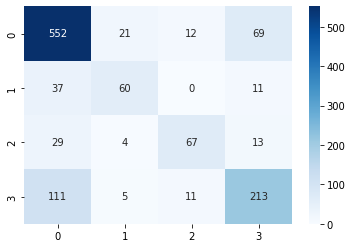

In [70]:
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

In [71]:
## TESTE COM REGRESSÃO LOGISTICA
lr = LogisticRegression()


lr.fit(X_train, y_train)                  # Emprega o conjunto de treinamento 

y_pred = lr.predict(X_test)

print(y_pred)

cm = confusion_matrix(y_test, y_pred)
print("MATRIZ DE CONFUSAO")
print(cm)
    
accuracy = accuracy_score(y_test, y_pred)
print("ACURACIDADE")
print(accuracy)

#F1-SCORE

#f1 = f1_score(y_test, y_pred)


print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average=None))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average=None))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average=None))

[1 0 0 ... 1 2 0]
MATRIZ DE CONFUSAO
[[588   9   7  50]
 [ 23  78   0   7]
 [ 18   2  75  18]
 [ 80   3  10 247]]
ACURACIDADE
0.8131687242798354
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       654
           1       0.85      0.72      0.78       108
           2       0.82      0.66      0.73       113
           3       0.77      0.73      0.75       340

    accuracy                           0.81      1215
   macro avg       0.81      0.75      0.78      1215
weighted avg       0.81      0.81      0.81      1215

F1 Score :  [0.86280264 0.78       0.73170732 0.74622356]
Precision Score :  [0.82933709 0.84782609 0.81521739 0.76708075]
Recall Score :  [0.89908257 0.72222222 0.66371681 0.72647059]


<AxesSubplot:>

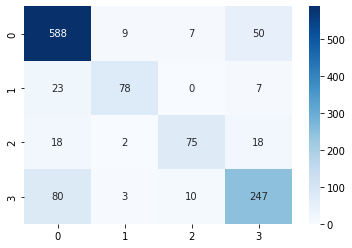

In [72]:
sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')